# Numerical shape updates

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
from pymedit import Mesh, P1Function, mmg2d, square, trunc, P1Vector, advect, mshdist
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8,8]
import numpy as np

Let us create a simple test mesh.

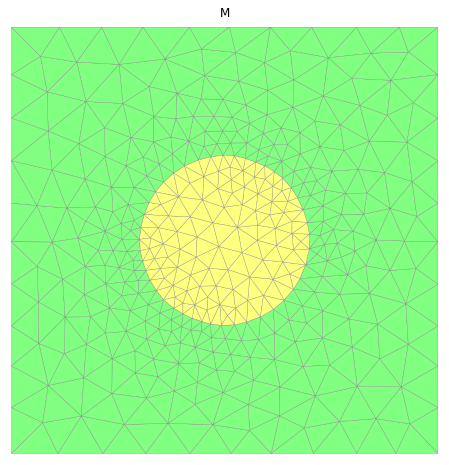

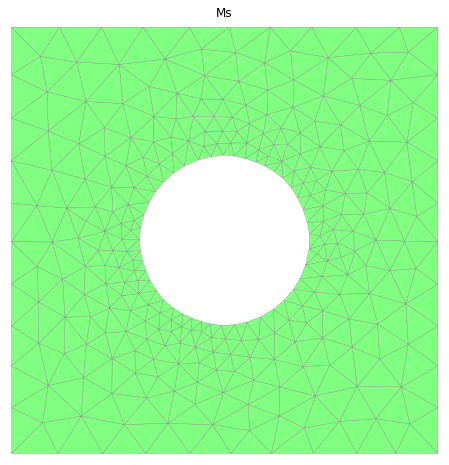

In [6]:
N=10
# Create a square centered at (0,0)
Th=square(N,N,lambda x,y : [x-0.5,y-0.5])
# Create a level set function for a disk
phi=P1Function(Th,lambda x: np.sqrt(x[0]**2+x[1]**2)-0.2)
hmin=0.01
hmax=0.1
hgrad=1.3
hausd=0.1*hmin

# Remesh the level set function and trunc
M=mmg2d(Th,hmin,hmax,hgrad,hausd,sol=phi,ls=True)
Ms=trunc(M,2)

M.plot(title='M')
Ms.plot(title='Ms');

In what follows, we wish to deform the circle boundary with respect to a radial vector field 

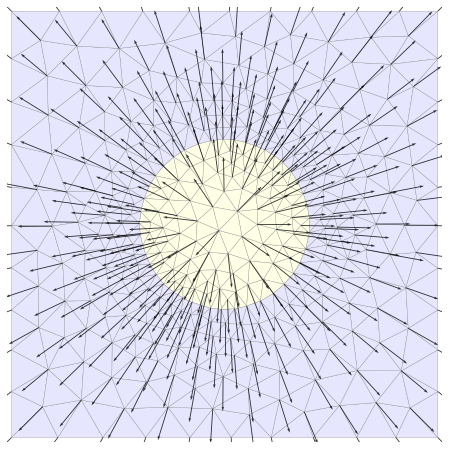

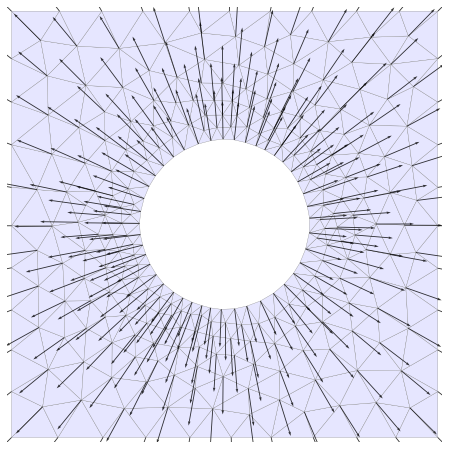

In [7]:
thetaM = P1Vector(M,lambda x : [x[0]/np.sqrt(x[0]**2+x[1]**2),x[1]/np.sqrt(x[0]**2+x[1]**2)])
thetaM.plot()
thetaMs = P1Vector(Ms,lambda x : [x[0]/np.sqrt(x[0]**2+x[1]**2),x[1]/np.sqrt(x[0]**2+x[1]**2)])
thetaMs.plot()

## 1. Moving mesh method

First, let us see what happens when we move all the points according to theta

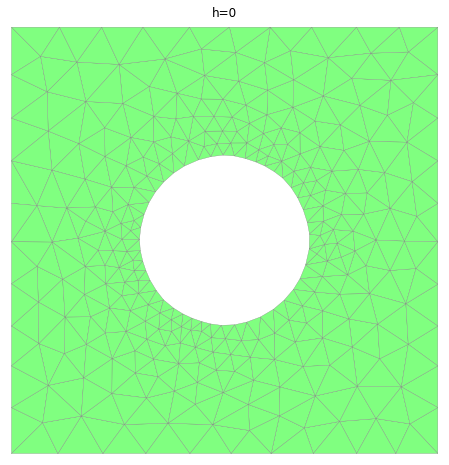

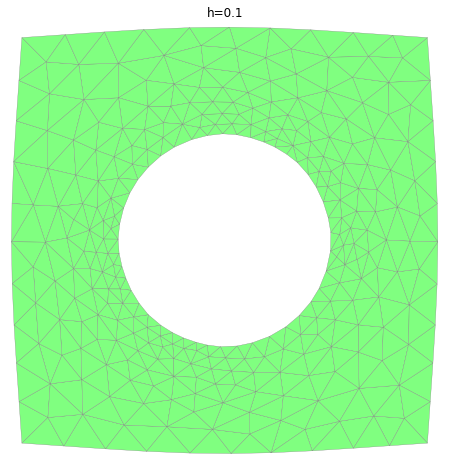

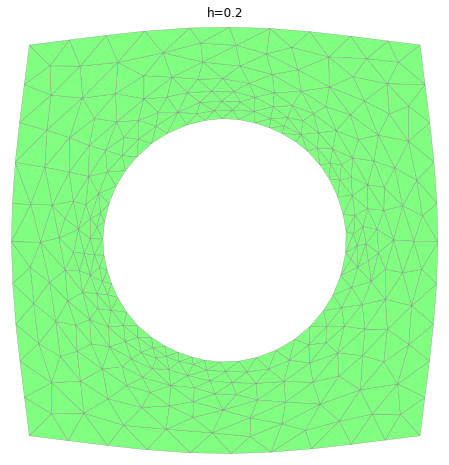

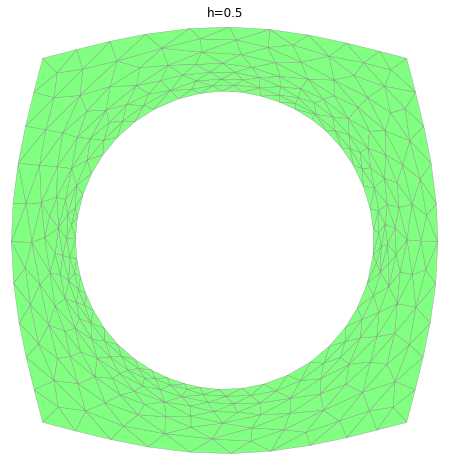

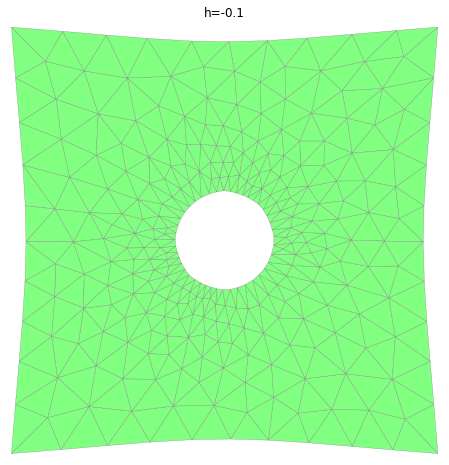

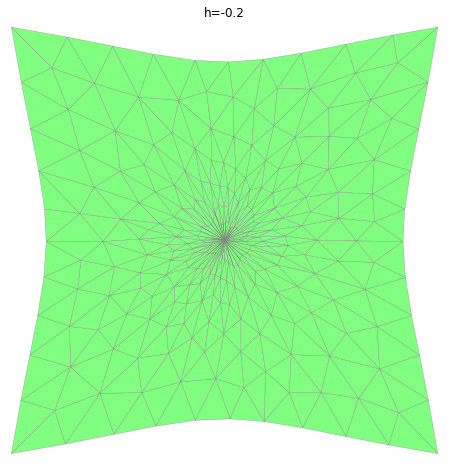

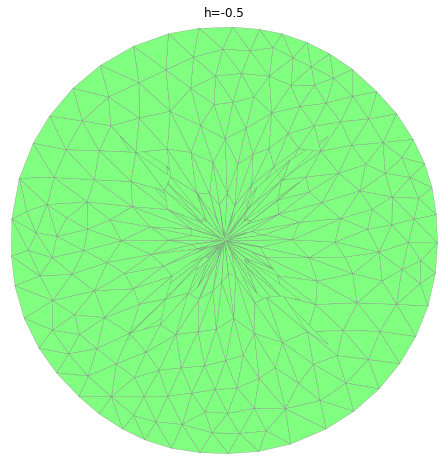

In [8]:
for h in [0,0.1,0.2,0.5,-0.1,-0.2,-0.5]:
    Ms2 = Ms.copy()
    Ms2.vertices[:,:-1] +=h*thetaMs.sol
    Ms2.plot(title=f'h={h}')

We now want to preserve the outer boundary (labels 1,2,3,4). For this, we create an extension $\widetilde{\theta}$ of theta by solving  the following Laplace problem:
$$
\newcommand{\In}{\text{ in }}
\newcommand{\On}{\text{ on }}
$$
    
$$
    \left\{\begin{aligned}
        -\Delta \widetilde{\theta} & =0\In D\\
        \widetilde{\theta}& = \theta \On \Gamma\\
        \widetilde{\theta} & = 0 \On \partial D.
    \end{aligned}\right.
$$
We are going to use FreeFEM to do this, with our library FreeFEMRunner to call it from python:

In [9]:
from pyfreefem import FreeFemRunner
# A function for reading solution files
preamble='''
load "medit";
func int readSolFile(mesh & Th, string fileName, real[int] & phi){
    ifstream f(fileName);
    string dummy="";
    while(dummy(0:2)!="Sol"){
        f>>dummy;
    }
    int n;
    f >> n;
    if(n!=Th.nv){
        cout << "Error : the number of vertices in the file "+fileName+" does not correspond to the mesh in memory" << endl;
        exit(1);
    }
    f >> dummy;
    f >> dummy;
    for(int i=0;i<Th.nv;i++){
        f>>phi[i];
    }
}
'''

The following code will export the mesh Ms and the vector field theta to FreeFem and solve the above extension problem.

In [10]:
code='''
//Read mesh and vector field
mesh Th=readmesh("$SCRIPTDIR/Th.mesh");
fespace Fh(Th,P1);
Fh thetax,thetay;
readSolFile(Th,"$SCRIPTDIR/thetax.sol",thetax[]);
readSolFile(Th,"$SCRIPTDIR/thetay.sol",thetay[]);

Fh u,v;
// Extend the function thetax
solve extendx(u,v)=int2d(Th)(dx(u)*dx(v)+dy(u)*dy(v))
    +on(1,2,3,4,u=0)
    +on(10,u=thetax);
savesol("$SCRIPTDIR/ux.sol",Th,u,order=1);

// Extend the function thetay
solve extendy(u,v)=int2d(Th)(dx(u)*dx(v)+dy(u)*dy(v))
    +on(1,2,3,4,u=0)
    +on(10,u=thetay);
savesol("$SCRIPTDIR/uy.sol",Th,u,order=1);
'''

with FreeFemRunner([preamble,code]) as runner:
    Ms.save(runner.script_dir+'/Th.mesh')
    thetaMs.x.save(runner.script_dir+'/thetax.sol')
    thetaMs.y.save(runner.script_dir+'/thetay.sol')
    runner.execute(verbosity=1,plot=True)
    ux = P1Function(Ms,runner.script_dir+'/ux.sol')
    uy = P1Function(Ms,runner.script_dir+'/uy.sol')
    u = P1Vector(Ms,[ux,uy])


            

-- FreeFem++ v4.1 (Tue 22 Feb 2022 10:08:09 AM CET - git v4.10)
   file : /tmp/pyfreefem_37twpj31/run.edp
 Load: lg_fem lg_mesh lg_mesh3 eigenvalue 
    1 : 
    2 : load "medit";
    3 : func int readSolFile(mesh & Th, string fileName, real[int] & phi){
    4 :     ifstream f(fileName);
    5 :     string dummy="";
    6 :     while(dummy(0:2)!="Sol"){
    7 :         f>>dummy;
    8 :     }
    9 :     int n;
   10 :     f >> n;
   11 :     if(n!=Th.nv){
   12 :         cout << "Error : the number of vertices in the file "+fileName+" does not correspond to the mesh in memory" << endl;
   13 :         exit(1);
   14 :     }
   15 :     f >> dummy;
   16 :     f >> dummy;
   17 :     for(int i=0;i<Th.nv;i++){
   18 :         f>>phi[i];
   19 :     }
   20 : }
   21 : //Read mesh and vector field
   22 : mesh Th=readmesh("/tmp/pyfreefem_37twpj31/Th.mesh");
   23 : fespace Fh(Th,P1);
   24 : Fh thetax,thetay;
   25 : readSolFile(Th,"/tmp/pyfreefem_37twpj31/thetax.sol",thetax[]);
   26 : 

The function u contains now the extended vector field:

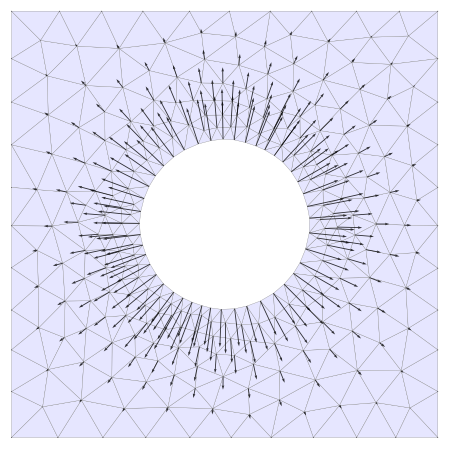

In [11]:
u.plot()

We can now deform the circle without deforming the boundary:

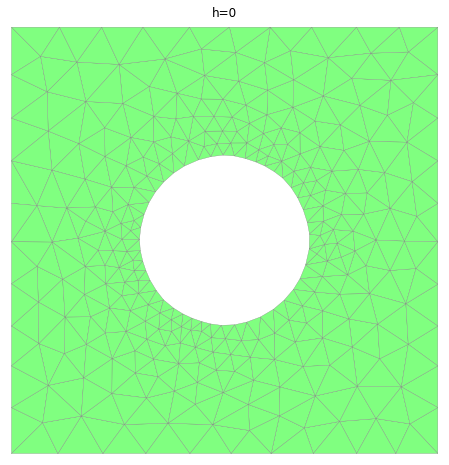

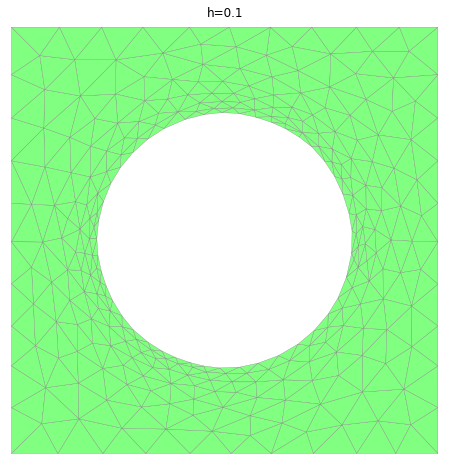

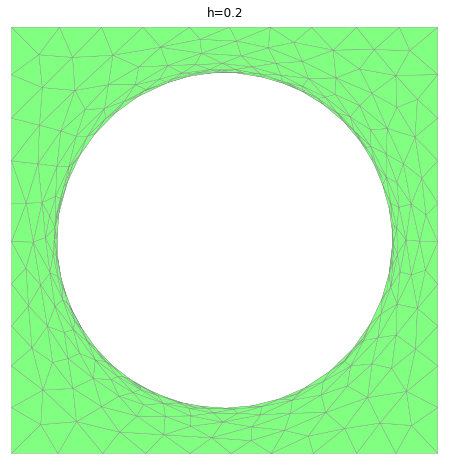

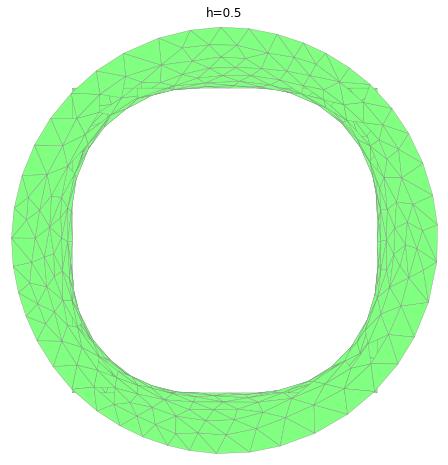

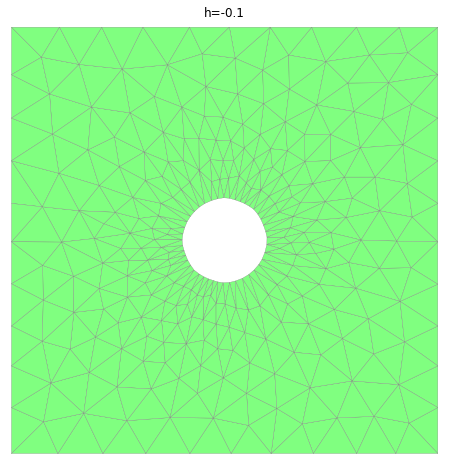

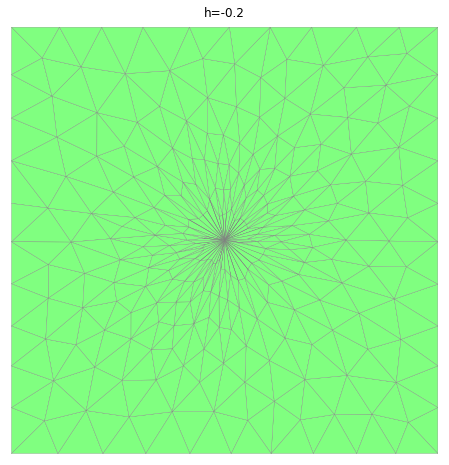

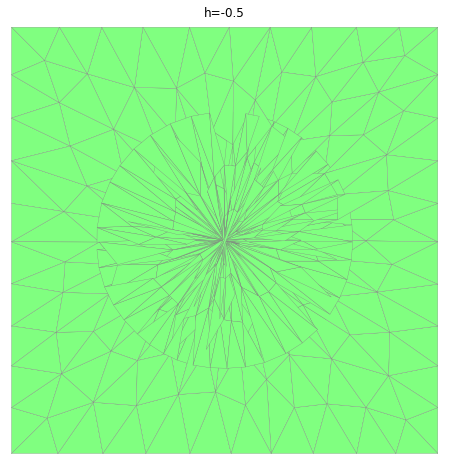

In [12]:
for h in [0,0.1,0.2,0.5,-0.1,-0.2,-0.5]:
    Ms2 = Ms.copy()
    Ms2.vertices[:,:-1] +=h*u.sol
    Ms2.plot(title=f'h={h}')

### Observe the appearance of flat, and then inverted triangles ! 

For later comparison, let us save the case h=0.2:

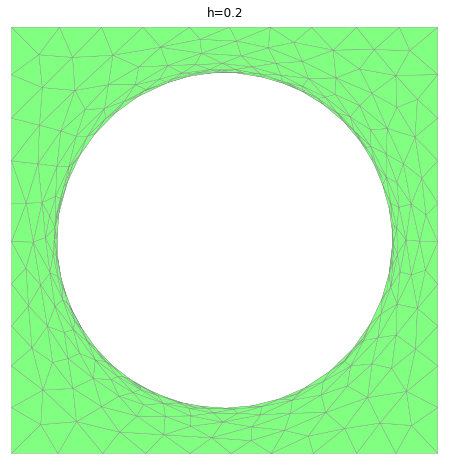

In [13]:
h=0.2
Ms2 = Ms.copy()
Ms2.vertices[:,:-1] +=h*u.sol
Ms2.plot(title=f'h={h}');

## 2. The level set method

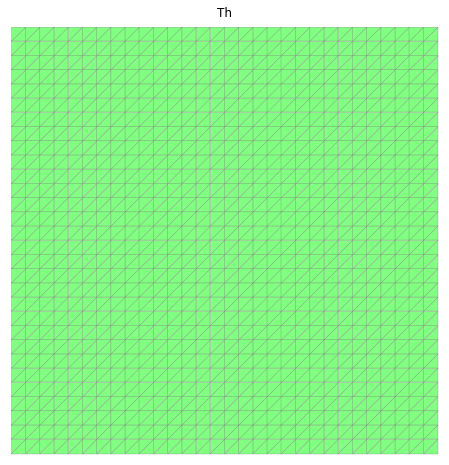

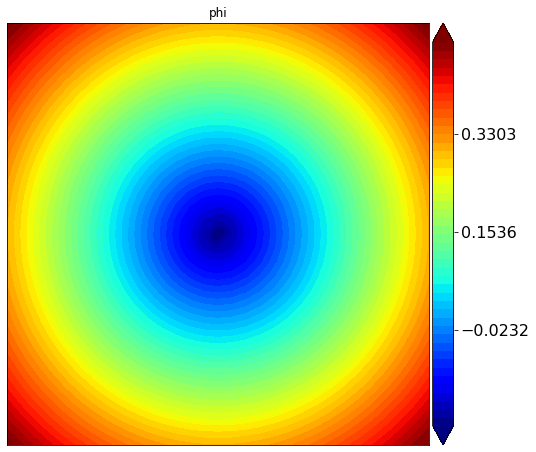

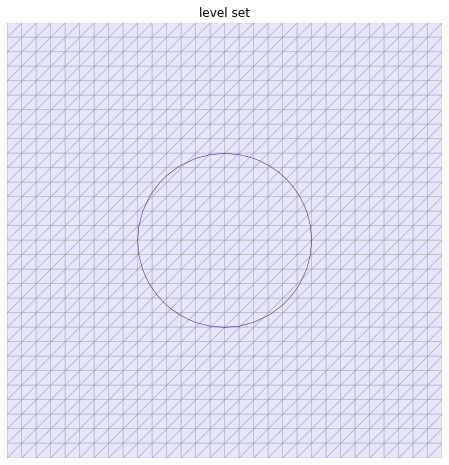

In [14]:
N=30
Th=square(N,N,lambda x,y : [x-0.5,y-0.5])
Th.plot(title='Th')
# Create a level set function for a disk
phi=P1Function(Th,lambda x: np.sqrt(x[0]**2+x[1]**2)-0.2)
phi.plot(title='phi')
phi.plot(title='level set',fill=False);

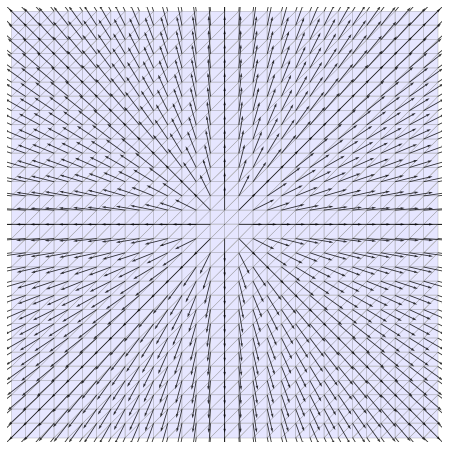

In [15]:
theta = P1Vector(Th,lambda x : [x[0]/np.sqrt(x[0]**2+x[1]**2+1e-9),x[1]/np.sqrt(x[0]**2+x[1]**2+1e-9)])
theta.plot()

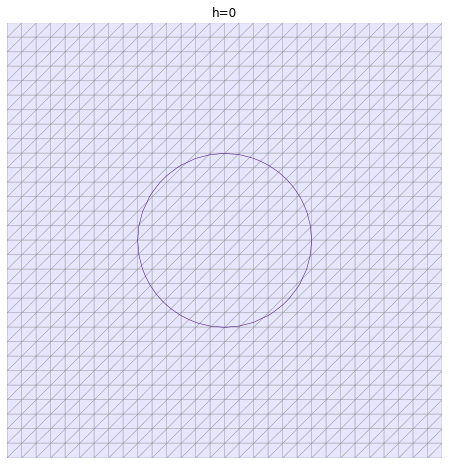

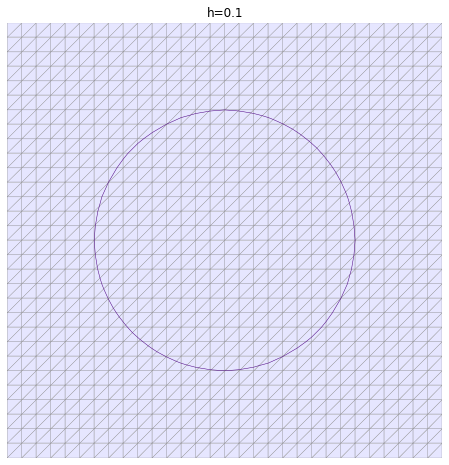

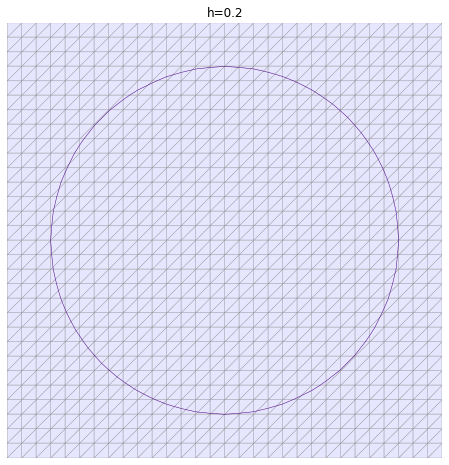

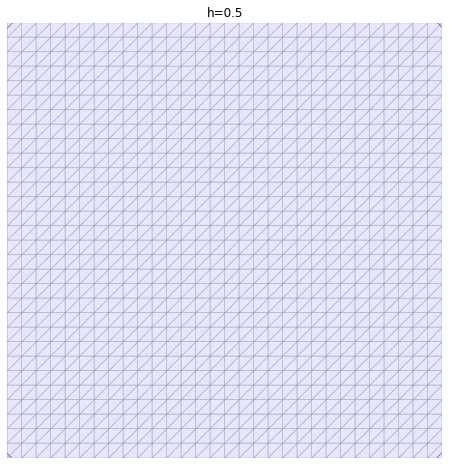

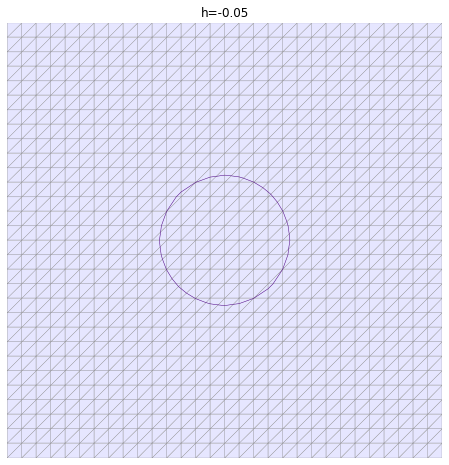

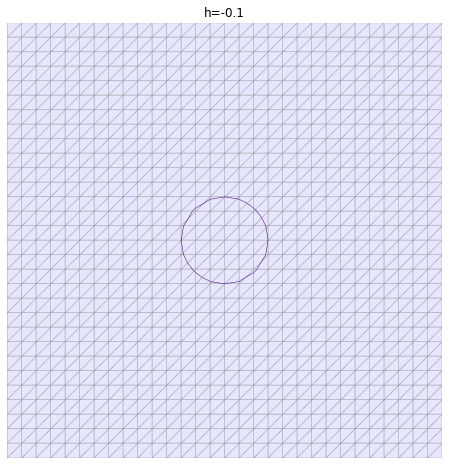

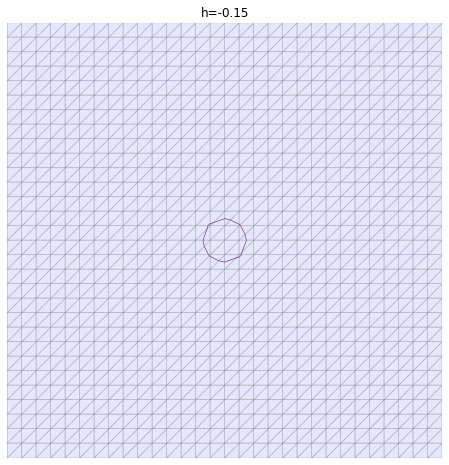

In [16]:
for h in [0,0.1,0.2,0.5,-0.05,-0.1,-0.15]:
    newphi=advect(Th,phi,theta*h,T=1)
    newphi.plot(fill=False,title=f'h={h}')
    

## 3. Body fitted meshes 

We come back to M to evolve the shape of a meshed subdomain.

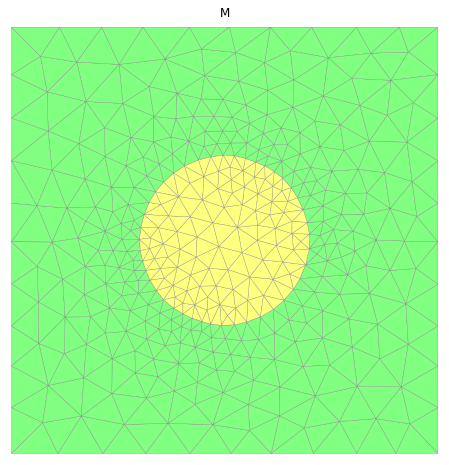

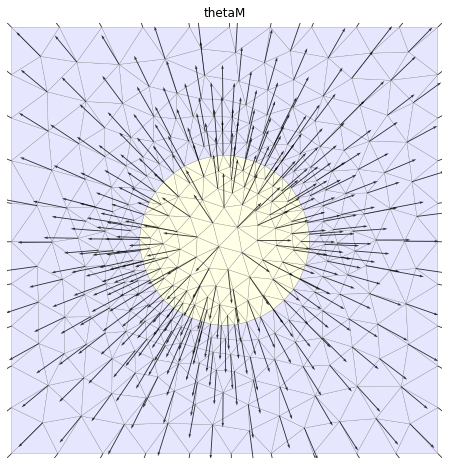

In [17]:
M.plot(title='M')
thetaM.plot(title='thetaM')

Let us compute the signed distance function to the domain as an initial level set function:

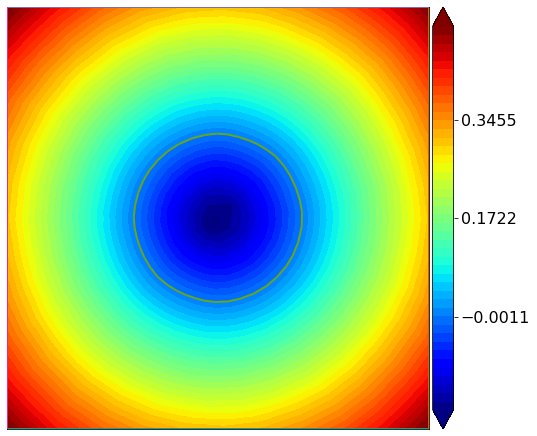

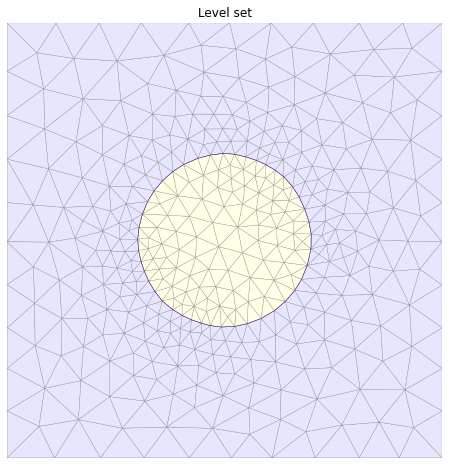

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:title={'center':'Level set'}>)

In [18]:
phi=mshdist(M)
phi.plot(boundary='all')
phi.plot(title="Level set",fill=False)

Observe that the level set coincide with the boundary triangles. Now advect the level set:

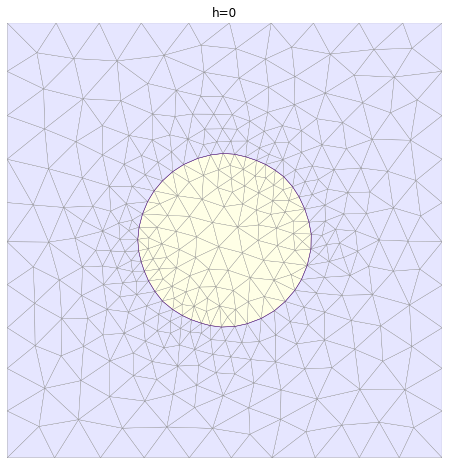

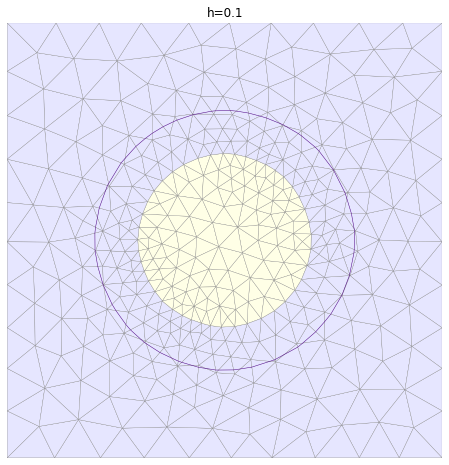

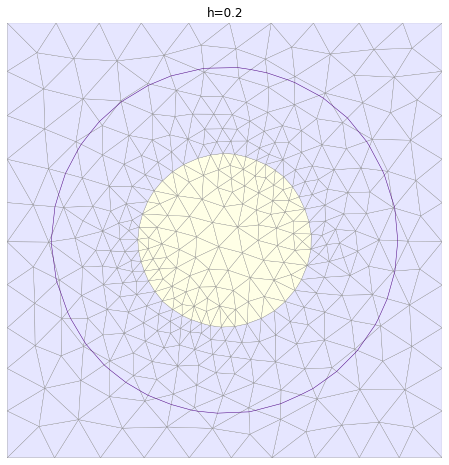

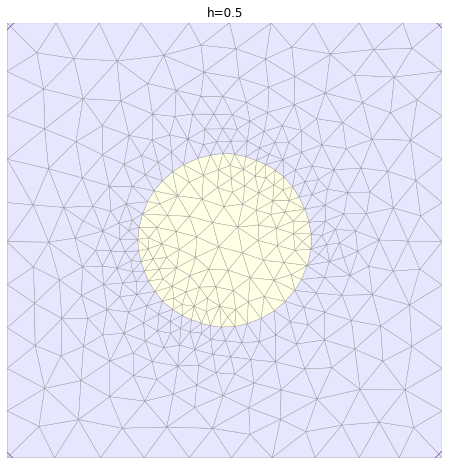

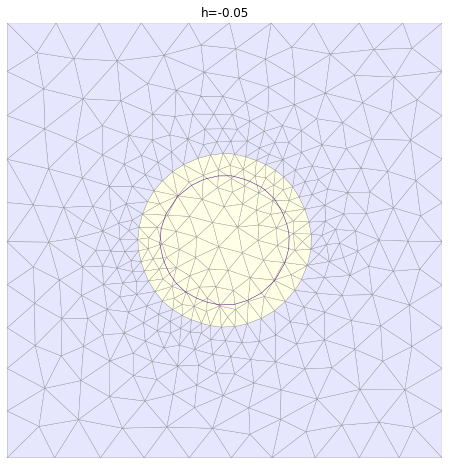

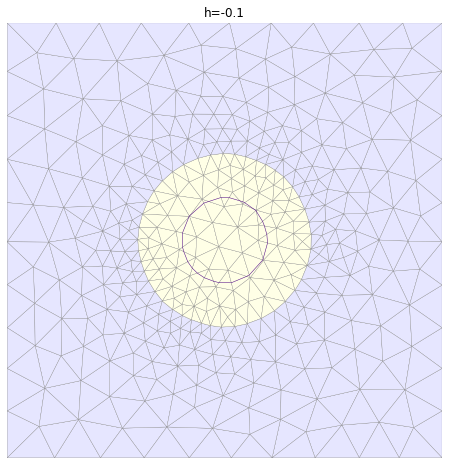

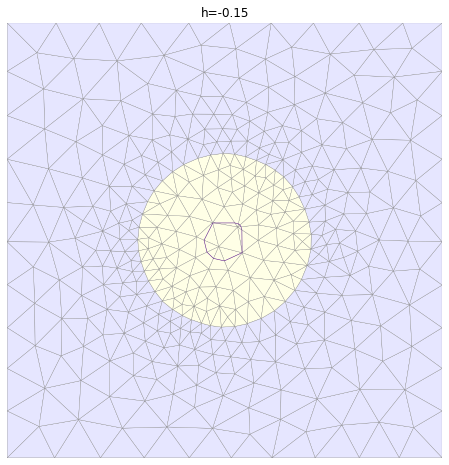

In [19]:
for h in  [0,0.1,0.2,0.5,-0.05,-0.1,-0.15]:
    phinew = advect(M,phi,h*thetaM,T=1)
    phinew.plot(fill=False,title=f'h={h}')

Finally, we can remesh according to the level set and obtain a new mesh with the deformed shape

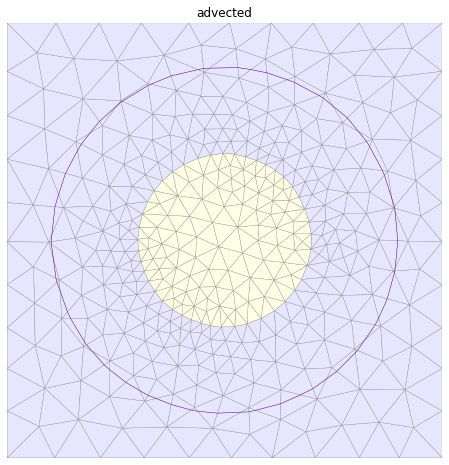

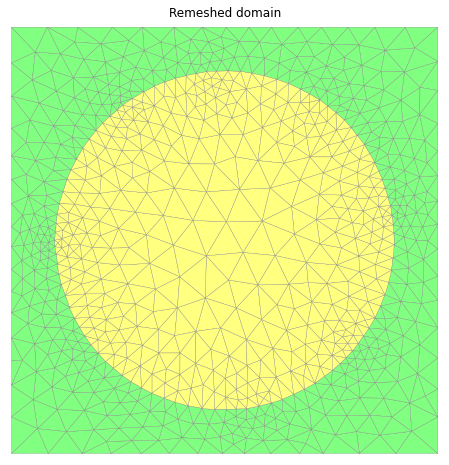

In [20]:
phinew = advect(M,phi,0.2*thetaM,T=1)
phinew.plot(title='advected',fill=False)
newM=mmg2d(M,hmin,hmax,hgrad,hausd,sol=phinew,ls=True)
newM.plot(title="Remeshed domain");

Compare with the result of the movemesh method:

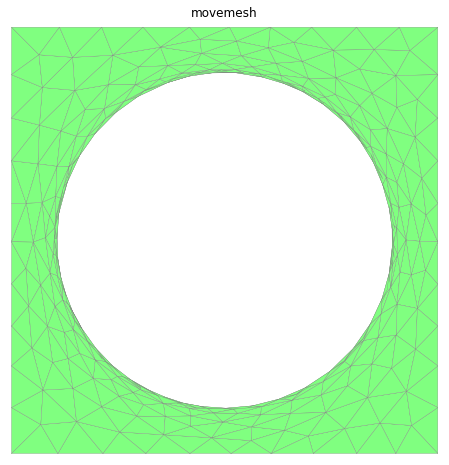

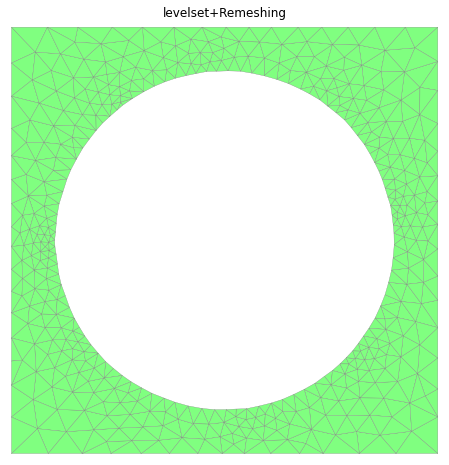

In [89]:
Ms2.plot(title='movemesh')
Ms2new = trunc(newM,2)
Ms2new.plot(title='levelset+Remeshing');